In [1]:
%cd ..

/home/zarizky/projects/neural-autoregressive-object-co-occurrence


In [2]:
from collections import OrderedDict
from math import log

import torch
import torch.nn.functional as F
import torch_optimizer as optim
from matplotlib import pyplot as plt
from torch import nn
from torch.utils import data
from tqdm.auto import tqdm

from made import MADE
from made.layer import MaskedAutoregressiveLinear
from utils.dataset import ObjectCooccurrenceCOCODataset

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

torch.manual_seed(0)

made = MADE(
    MaskedAutoregressiveLinear(80, 128, condition=False),
    nn.ReLU(),
    MaskedAutoregressiveLinear(128, 80, out_dims=29, condition=False),
)

dataset = dict()
dataset["train"] = ObjectCooccurrenceCOCODataset(
    "dataset/coco2017-cooccurences-train.csv"
)
dataset["test"] = ObjectCooccurrenceCOCODataset(
    "dataset/coco2017-cooccurences-valid.csv"
)

dataloader = dict()
dataloader["train"] = data.DataLoader(
    dataset["train"],
    batch_size=8196,
    shuffle=True,
    num_workers=8,
    pin_memory=device in ["cuda", "mps"],
)
dataloader["test"] = data.DataLoader(
    dataset["test"],
    batch_size=8196,
    shuffle=False,
    num_workers=8,
    pin_memory=device in ["cuda", "mps"],
)

print("Total Parameters\t: {:,}".format(sum(p.numel() for p in made.parameters())))

Total Parameters	: 309,648


In [4]:
epochs = 500
num_sample_train = 1
num_sample_test = 100
patience_max = 100
eps = 1e-10

made = made.to(device)
opt = optim.Lamb(made.parameters(), lr=1e-5)
sch = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=opt, max_lr=1e-2, steps_per_epoch=len(dataloader["train"]), epochs=epochs
)

record = []
with tqdm(total=epochs, unit="epoch") as pbar:
    patience = 1
    loss_best = torch.inf
    for i in range(epochs):
        pbar.set_description(f"[patience: {patience}/{patience_max}]")

        loss_train = 0
        loss_test = 0

        made.train()
        for inputs in dataloader["train"]:
            inputs = inputs.float().to(device)

            loss = 0
            for _ in range(num_sample_train):
                dist = torch.distributions.Categorical(logits=made(inputs))
                dist = torch.distributions.Independent(dist, 1)
                loss = loss - dist.log_prob(inputs).sum()
            loss = loss / (num_sample_train * inputs.size(0))

            loss.backward()
            opt.step()
            sch.step()
            opt.zero_grad()

        made.eval()
        with torch.inference_mode():
            for inputs in dataloader["train"]:
                inputs = inputs.float().to(device)

                sample = []
                for _ in range(num_sample_test):
                    dist = torch.distributions.Categorical(logits=made(inputs))
                    dist = torch.distributions.Independent(dist, 1)
                    sample.append(dist.log_prob(inputs) - log(num_sample_test))
                sample = torch.stack(sample, 1)
                loss = sample.logsumexp(-1).sum().neg()

                loss_train += loss.item()

            for inputs in dataloader["test"]:
                inputs = inputs.float().to(device)

                sample = []
                for _ in range(num_sample_test):
                    dist = torch.distributions.Categorical(logits=made(inputs))
                    dist = torch.distributions.Independent(dist, 1)
                    sample.append(dist.log_prob(inputs) - log(num_sample_test))
                sample = torch.stack(sample, 1)
                loss = sample.logsumexp(-1).sum().neg()

                loss_test += loss.item()

        loss_train /= len(dataset["train"])
        loss_test /= len(dataset["test"])

        history = OrderedDict(
            loss=loss_train,
            val_loss=loss_test,
        )

        if loss_best > (loss_current := history["val_loss"]):
            patience = 1
            loss_best = loss_current
        else:
            patience = patience + 1

        record.append(history)

        for key, value in history.items():
            history[key] = str(round(value, 4))

        pbar.set_postfix(history)
        pbar.update()

        if patience > patience_max:
            break

  0%|          | 0/500 [00:00<?, ?epoch/s]

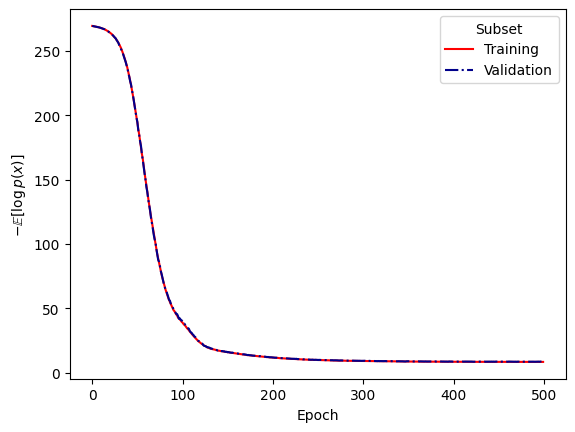

In [5]:
loss = [float(history["loss"]) for history in record]
val_loss = [float(history["val_loss"]) for history in record]

plt.xlabel("Epoch")
plt.ylabel("$-\mathbb{E}[\log p(x)]$")

plt.plot(loss, "-", color="red", label="Training")
plt.plot(val_loss, "-.", color="darkblue", label="Validation")
plt.legend(title="Subset")
plt.show()